<a href="https://colab.research.google.com/github/adrien50/earthquake-damage-pridiction/blob/master/earthquake_damage_pridiction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Richter's Predictor: Modeling Earthquake Damage**

**Overview**

Based on aspects of building location and construction, your goal is to predict the level of damage to buildings caused by the 2015 Gorkha earthquake in Nepal. AI can leverage human life and potentially save them from disasters in the coming future. One such small step towards this far but promising future is to use data from past and find some patterns which are universal in nature and which can promise some accurate prediction thereby helping humans minimize the effects of disaster. 

Predicting potential damage on a building can help us to take precautions before an earthquake occurs. If we know the features of a building such as age, height, number of floors, etc. we can predict the potential damage level to that building when an earthquake hits. [Richter predictor](https://www.kaggle.com/valentindefour/richter-predictor-nepalese-earthquake-damages) and 
[Top 4% submission ](https://www.kaggle.com/andreicosmin/top-4-submission) from kaggle helped me a lot

**IMPORTING USEFUL LIBRARIES**

In [ ]:
import numpy as np
import pandas as pd
import xgboost as xgb
import pprint

import seaborn as sb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, f1_score, confusion_matrix

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import xgboost as xgb

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


**LOADING DATA**

In [ ]:
train = pd.read_csv("train_values.csv")
target = pd.read_csv("train_labels.csv")
test = pd.read_csv("test_values.csv")


**Features**

The dataset mainly consists of information on the buildings' structure and their legal ownership. Each row in the dataset represents a specific building in the region that was hit by Gorkha earthquake.
There are 39 columns in this dataset, where the building_id column is a unique and random identifier. The remaining 38 features are described in the section below. Categorical variables have been obfuscated random lowercase ascii characters. The appearance of the same character in distinct columns does not imply the same original value.


**Problem description**

We're trying to predict the ordinal variable damage_grade, which represents a level of damage to the building that was hit by the earthquake.

There are 3 grades of the damage:

-represents low damage

-represents a medium amount of damage

-represents almost complete destruction

# List Of Features: 
* `geo_level_1_id`, `geo_level_2_id`, `geo_level_3_id` : `INT` geographic region in which building exists, from largest (level 1) to most specific sub-region (level 3). Possible values: level 1: 0-30, level 2: 0-1427, level 3: 0-12567
* `count_floors_pre_eq` : `INT` number of floors in the building before the earthquake
* `age` : `INT` age of the building in years
* `area_percentage` : `INT`  normalized area of the building footprint
* `height_percentage` : `INT` normalized height of the building footprint
* `land_surface_condition` : `Categorical` :-  `n`, `o`, `t`
* `foundation_type` : `Categorical` :- `h`, `i`, `r`, `u`, `w`

and Many More...

In [ ]:
train.head()

,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,legal_ownership_status,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
0,802906,6,487,12198,2,30,6,5,t,r,n,f,q,t,d,1,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
1,28830,8,900,2812,2,10,8,7,o,r,n,x,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
2,94947,21,363,8973,2,10,5,5,t,r,n,f,x,t,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
3,590882,22,418,10694,2,10,6,5,t,r,n,f,x,s,d,0,1,0,0,0,0,1,1,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
4,201944,11,131,1488,3,30,8,9,t,r,n,f,x,s,d,1,0,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 260601 entries, 0 to 260600
Data columns (total 39 columns):
 #   Column                                  Non-Null Count   Dtype 
---  ------                                  --------------   ----- 
 0   building_id                             260601 non-null  int64 
 1   geo_level_1_id                          260601 non-null  int64 
 2   geo_level_2_id                          260601 non-null  int64 
 3   geo_level_3_id                          260601 non-null  int64 
 4   count_floors_pre_eq                     260601 non-null  int64 
 5   age                                     260601 non-null  int64 
 6   area_percentage                         260601 non-null  int64 
 7   height_percentage                       260601 non-null  int64 
 8   land_surface_condition                  260601 non-null  object
 9   foundation_type                         260601 non-null  object
 10  roof_type                               260601 non-null 

#**There are no missing values**

In [ ]:
target.head()

,building_id,damage_grade
0,802906,3
1,28830,2
2,94947,3
3,590882,2
4,201944,3


In [ ]:
target.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 260601 entries, 0 to 260600
Data columns (total 2 columns):
 #   Column        Non-Null Count   Dtype
---  ------        --------------   -----
 0   building_id   260601 non-null  int64
 1   damage_grade  260601 non-null  int64
dtypes: int64(2)
memory usage: 4.0 MB


# Now, we will merge the two dataset

In [ ]:
train = pd.merge(train, target, on = 'building_id', how = 'left')
train.set_index('building_id', drop = True, inplace = True)
test.set_index('building_id', drop = True, inplace = True)

In [ ]:
train.head()

,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,legal_ownership_status,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,damage_grade
building_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
802906,6,487,12198,2,30,6,5,t,r,n,f,q,t,d,1,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,3
28830,8,900,2812,2,10,8,7,o,r,n,x,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,2
94947,21,363,8973,2,10,5,5,t,r,n,f,x,t,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,3
590882,22,418,10694,2,10,6,5,t,r,n,f,x,s,d,0,1,0,0,0,0,1,1,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,2
201944,11,131,1488,3,30,8,9,t,r,n,f,x,s,d,1,0,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,3


In [ ]:
train.info

<bound method DataFrame.info of              geo_level_1_id  ...  damage_grade
building_id                  ...              
802906                    6  ...             3
28830                     8  ...             2
94947                    21  ...             3
590882                   22  ...             2
201944                   11  ...             3
...                     ...  ...           ...
688636                   25  ...             2
669485                   17  ...             3
602512                   17  ...             3
151409                   26  ...             2
747594                   21  ...             3

[260601 rows x 39 columns]>

We have a total of 39 parameters, mostly numerical values, with a few of them being string values. We'll transform these strings to numerical / categorical values further.

# Few vizualizations to discover the data we have to work with

2    148259
3     87218
1     25124
Name: damage_grade, dtype: int64


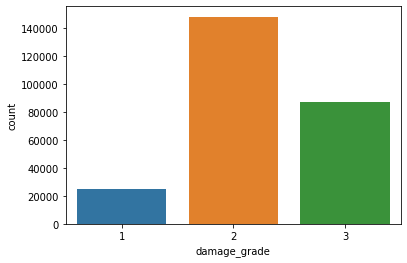

In [ ]:
sb.countplot(train['damage_grade'])
print(train['damage_grade'].value_counts())

**The majority, >50% buildings were labeled with damage_grade = 2, while only ~25,000, <10% buildings were labeled as mildly damaged (damage_grade = 1)**

**Let's have a look at the superstrctures**

In [ ]:
train.iloc[:,[i for i in range(15, 26)]].head()

,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,legal_ownership_status
building_id,,,,,,,,,,,
802906,1,0,0,0,0,0,0,0,0,0,v
28830,1,0,0,0,0,0,0,0,0,0,v
94947,1,0,0,0,0,0,0,0,0,0,v
590882,1,0,0,0,0,1,1,0,0,0,v
201944,0,0,0,0,0,0,0,0,0,0,v


**We can see just from the first 5 rows, that some buildings have superstructures from multiple materials.**

In [ ]:
train.iloc[:,[i for i in range(27, 39)]].head()

,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,damage_grade
building_id,,,,,,,,,,,,
802906,0,0,0,0,0,0,0,0,0,0,0,3
28830,0,0,0,0,0,0,0,0,0,0,0,2
94947,0,0,0,0,0,0,0,0,0,0,0,3
590882,0,0,0,0,0,0,0,0,0,0,0,2
201944,0,0,0,0,0,0,0,0,0,0,0,3


In [ ]:
train.has_secondary_use.mean()

0.11187984696912137

**Let's see whether there are buildings with multiple secondary uses by summing up the means and see whether it's equal to the has_secondary_use mean**

In [ ]:
count = 0
for i in range(28, 39):
    col = train.columns[i]
    count+=train[col].mean()
print(f'The sum of means of the secondary_use columns is {count}')

The sum of means of the secondary_use columns is 2.352289515389427


**This is slightly larger than the previous mean, so there is a very small number of buildings with multiple secondary uses**



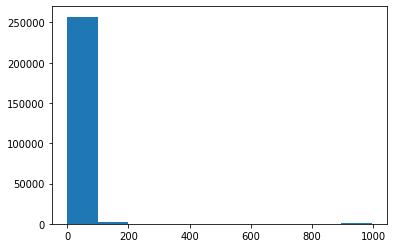

In [ ]:
plt.hist(train.age)
plt.show()

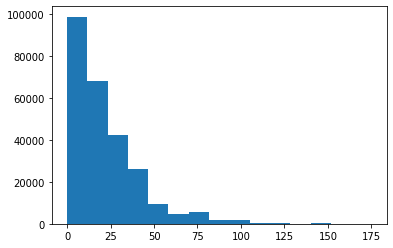

In [ ]:
plt.hist(train.age,range=(0,175), bins = 15)
plt.show()

**We see that Most buildings are aged 0-50**

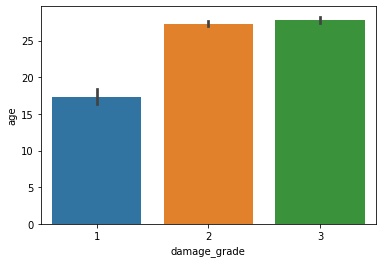

In [ ]:
sb.barplot('damage_grade', 'age', data = train)

**We can conclude that Newer buildings where less damaged.**

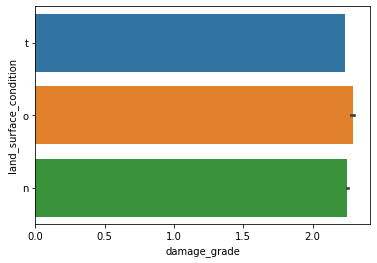

In [ ]:
sb.barplot('damage_grade', 'land_surface_condition', data= train)

**There is little correlation between land surface condition and damage grade**

In [ ]:
#14- 25 are columns containing superstructure info
cols = []
for i in range(14, 25):
    cols.append(train.columns[i])

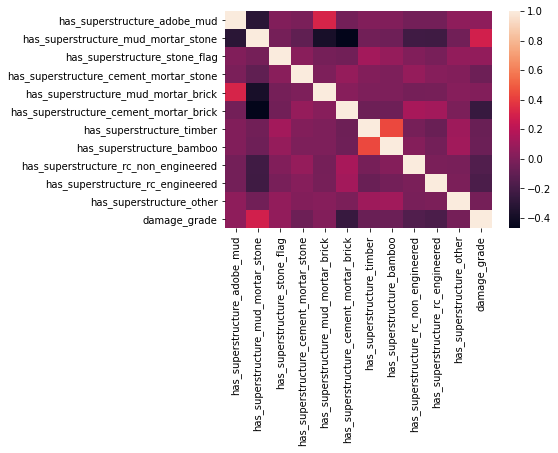

In [ ]:
corr = train[cols+['damage_grade']].corr()
sb.heatmap(corr)

**Mud mortar stone homes is strongly correlated with a higher damage grade, while cement mortar brick were least damaged**


**We can see it through pearson correlation**

In [ ]:
import scipy
scipy.stats.pearsonr(train.damage_grade, train.has_superstructure_mud_mortar_stone)

(0.2913252386818046, 0.0)

In [ ]:
scipy.stats.pearsonr(train.damage_grade, train.has_superstructure_cement_mortar_brick)

(-0.25413098113141863, 0.0)

**Some of the superstrcture values are strongly positively or negatively correlated between them.**

In [ ]:
cols = []
for i in range(14, 25):
    cols.append(train.columns[i])

In [ ]:
secondary_use = []
for i in range(27, 37):
    secondary_use.append(train.columns[i])

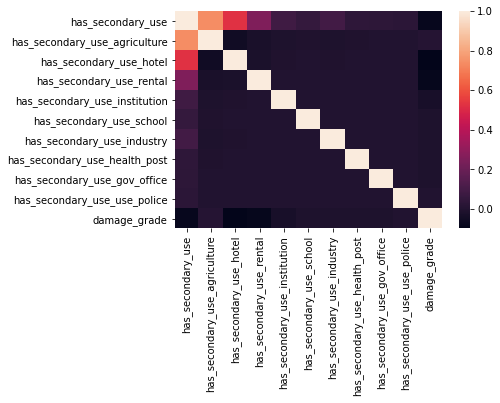

In [ ]:
corr = train[secondary_use +['damage_grade']].corr()
sb.heatmap(corr)

**no relation between seconday use and damage grade**

# change the object type columns to int

In [ ]:
train.dtypes.value_counts()

int64     31
object     8
dtype: int64

In [ ]:
txt_features = []
for c in train.columns:
    if train[c].dtype == 'object':
        txt_features.append(c)

for f in txt_features:
    train = train.join(pd.get_dummies(train[f], prefix = f))
    test = test.join(pd.get_dummies(test[f], prefix = f))
    
    train.drop(f, axis = 1, inplace = True)
    test.drop(f, axis = 1, inplace = True)
features = train.drop('damage_grade', axis = 1).columns

In [ ]:
train.head()

,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,damage_grade,land_surface_condition_n,land_surface_condition_o,land_surface_condition_t,foundation_type_h,foundation_type_i,foundation_type_r,foundation_type_u,foundation_type_w,roof_type_n,roof_type_q,roof_type_x,ground_floor_type_f,ground_floor_type_m,ground_floor_type_v,ground_floor_type_x,ground_floor_type_z,other_floor_type_j,other_floor_type_q,other_floor_type_s,other_floor_type_x,position_j,position_o,position_s,position_t,plan_configuration_a,plan_configuration_c,plan_configuration_d,plan_configuration_f,plan_configuration_m,plan_configuration_n,plan_configuration_o,plan_configuration_q,plan_configuration_s,plan_configuration_u,legal_ownership_status_a,legal_ownership_status_r,legal_ownership_status_v,legal_ownership_status_w
building_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
802906,6,487,12198,2,30,6,5,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,3,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0
28830,8,900,2812,2,10,8,7,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,2,0,1,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
94947,21,363,8973,2,10,5,5,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,3,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0
590882,22,418,10694,2,10,6,5,0,1,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,2,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
201944,11,131,1488,3,30,8,9,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,3,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0


#**Train Test Split**

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(train[features], train.damage_grade, random_state = 42)

# We will start with  RandomForestClassifier 

In [ ]:
rf = RandomForestClassifier()
model = rf.fit(X_train, Y_train)
model.score(X_test, Y_test)

0.7112093444459794

#F1 score is used for model accuracy

In [ ]:
y_pred = model.predict(X_test)
f1_score(Y_test, y_pred,average='micro')

0.7112093444459794

#We will look at the confusion matrix

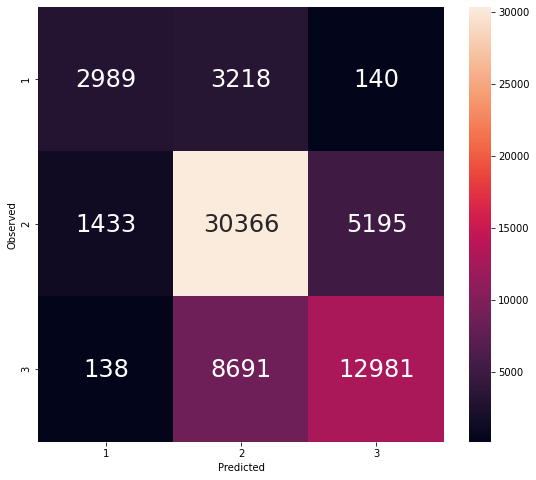

In [ ]:
cm_rf = pd.DataFrame(confusion_matrix(Y_test, y_pred), columns=np.unique(Y_test), index = np.unique(Y_test))
cm_rf.index.name = 'Observed'
cm_rf.columns.name = 'Predicted'
plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
sb.heatmap(cm_rf, annot=True, fmt='d', annot_kws={"size": 24})

**The model is overestimating the buildings with damage_grade = 2 : 36,994 observed and 42,275 predicted: 5,281 buildings more, almost 15%.**

#Let look at the features importance: Top 10 Random Forest importance

In [ ]:
importance_features = pd.DataFrame({"Features":features, "Importance_features":rf.feature_importances_}).sort_values(by='Importance_features', ascending = False).head(10)
importance_features

,Features,Importance_features
2,geo_level_3_id,0.154058
1,geo_level_2_id,0.135723
0,geo_level_1_id,0.133796
4,age,0.120487
5,area_percentage,0.111755
6,height_percentage,0.056856
18,count_families,0.024519
3,count_floors_pre_eq,0.016242
35,foundation_type_r,0.013730
8,has_superstructure_mud_mortar_stone,0.013693


**We see here that, for the Random Forest, the geographical data has the highest impact**

#We will fit the train data to common classifiers to see which one of these performs better on a first approach:

In [ ]:
classifiers = [KNeighborsClassifier(),
               DecisionTreeClassifier(),
               RandomForestClassifier(),
               GradientBoostingClassifier()]

def test_models(classifiers):
    
    for model in classifiers:
        
        model.fit(X_train, Y_train)
        y_pred = model.predict(X_test)
        
        print(model)
        score = f1_score(Y_test, y_pred, average='micro')
        print(score)
        print('############')

In [ ]:
test_models(classifiers)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')
0.7030590474436309
############
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')
0.6565056560912342
############
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples

#We can conclude that Random Forest Classifier performed the best followed by KNN.


# Let's see if there are outliers 

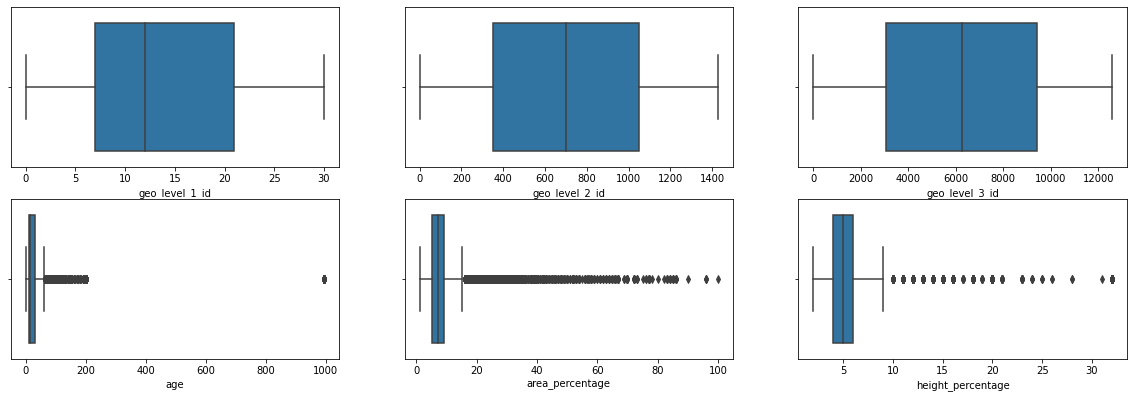

In [ ]:
num_f = ['geo_level_1_id','geo_level_2_id','geo_level_3_id','age','area_percentage','height_percentage']
i = 1

plt.figure(figsize=(20,10))

for col in num_f:
    plt.subplot(3,3,i)
    ax=sb.boxplot(train[col].dropna())
    plt.xlabel(col)
    i+=1
plt.show()

**No outliers for the geolocation data, however there are some for the age and normalized area/height of the building footprint**

**Z scores can be used instead to filter data, with the risk of removing some useful data points. To avoid losing useful data, the importance data-frame will be used in order to only drop rows which contain outliers for relevant variables.**

In [ ]:
def remove_outliers(dat_f, cut = 0.01, z_score = 3.5): #define a function to get rid of all outliers of the most important columns
    cols = importance_features[importance_features.Importance_features>cut]['Features'].tolist() #get all columns with importance > 0.01.  
    new_dat = dat_f.copy() #init the new df
    for col in cols: new_dat = new_dat[np.abs(scipy.stats.zscore(new_dat[col]))<z_score] #removing all rows where a z-score is >3
    return new_dat

In [ ]:
dat_f = pd.concat([train[features], train.damage_grade], axis = 1)
new_dat = remove_outliers(dat_f)

In [ ]:
y = new_dat.pop('damage_grade')
x=new_dat

In [ ]:
# a function that will later be used to divide dataframe into x(independent variables) and y(dependent variable)
def get_dat(dat_f):
    y = dat_f.pop('damage_grade')
    x= dat_f
    return x, y

In [ ]:
y = dat_f.damage_grade
x = dat_f.drop('damage_grade', axis = 1)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.1, random_state = 42)

In [ ]:
def model_test(model, removing = False, cut = 0.01, z_score = 3.5):
    daf_train = pd.concat([x_train, y_train], axis = 1) #combine them together, so outliers are simultaneously removed from both
    if removing: daf_train = remove_outliers(daf_train, cut, z_score) 
    x, y =get_dat(daf_train)
    model.fit(x, y)

    y_pred = model.predict(x_test)
    print(f1_score(y_test, y_pred, average='micro'))
model_test(xgb.XGBRFClassifier())

0.6333985649054142


In [ ]:
models = [xgb.XGBRFClassifier(), xgb.XGBClassifier()]
for model in models:
    print(model.__class__.__name__, 'score:',end =' ')
    model_test(model, True)

XGBRFClassifier score: 0.6333601933924254
XGBClassifier score: 0.6752235140631595


There is is no improvement observed following outlier removal.

However, XGBClassifier is giving a  better score, but it is not better than random forest classifier.

**Random Forest Classifier will be chosen for the submission**

#**Saving the final model using Joblib¶**

In [ ]:
import joblib
filename = 'final_model.sav' # Name of the model 
joblib.dump(rf, filename) # it is saved in your current working directory

['final_model.sav']

In [ ]:
# This command loads the model once again
load_model = joblib.load(filename)